#Sketch to image (For faces)

In [ ]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.models import inception_v3
import torchvision.transforms as T

import matplotlib.pyplot as plt
import torchvision.utils as vutils
import imageio

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.linalg import sqrtm
import lpips

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# celeba_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'

!unzip celeba_hq_256.zip -d ./celeba_hq_256

Streaming output truncated to the last 5000 lines.
  inflating: ./celeba_hq_256/celeba_hq_256/27144.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._27144.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/07294.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._07294.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/28277.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._28277.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/29169.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._29169.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/10930.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._10930.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/16399.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._16399.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/21535.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq_256/._21535.jpg  
  inflating: ./celeba_hq_256/celeba_hq_256/01183.jpg  
  inflating: ./celeba_hq_256/__MACOSX/celeba_hq

In [ ]:
class SketchPhotoDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.image_names = os.listdir(image_dir)[:5000]
        #self.image_names = [f for f in os.listdir(image_dir)
                   # if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('__')][:5000]

        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_names)

    def convert_to_sketch(self,image):
        # Step 1: Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Step 2: Invert the grayscale image
        inverted = 255 - gray

        # Step 3: Apply Gaussian blur to the inverted image
        blur = cv2.GaussianBlur(inverted, (21, 21), sigmaX=0, sigmaY=0)

        # Step 4: Dodge blend
        dodge = cv2.divide(gray, 255 - blur, scale=256)

        # Step 5: Apply Laplacian edge detection for enhancement
        edges = cv2.Laplacian(gray, cv2.CV_8U, ksize=5)
        edges = cv2.GaussianBlur(edges, (3, 3), 0)

        # Step 6: Blend sketch and edges
        sketch = cv2.subtract(dodge, edges // 3)
        sketch = np.clip(sketch, 0, 255).astype(np.uint8)

        # Step 6: Reduce noise while preserving pencil strokes using fastNlMeansDenoising.
        # h: Filter strength, templateWindowSize: size in pixels, searchWindowSize: size in pixels for neighborhood search.
        sketch = cv2.fastNlMeansDenoising(sketch, h=15, templateWindowSize=7, searchWindowSize=21)

        return sketch

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            raise ValueError(f"Image not found: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.image_size)

        sketch = self.convert_to_sketch(image)
        sketch = cv2.resize(sketch, self.image_size)

        # Convert single-channel sketch to 3-channel
        sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)

        if self.transform:
            image = self.transform(image)                      # RGB image
            sketch = self.transform(sketch)                    # Now also RGB
        else:
            image = transforms.ToTensor()(image)
            sketch = transforms.ToTensor()(sketch)

        return sketch, image


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] for GANs
])

celeba_dir = './celeba_hq_256/celeba_hq_256'

# Define your dataset
dataset = SketchPhotoDataset(celeba_dir, transform=transform)

# Calculate lengths for train and validation sets
total_size = len(dataset)
val_size = int(0.1 * total_size)
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

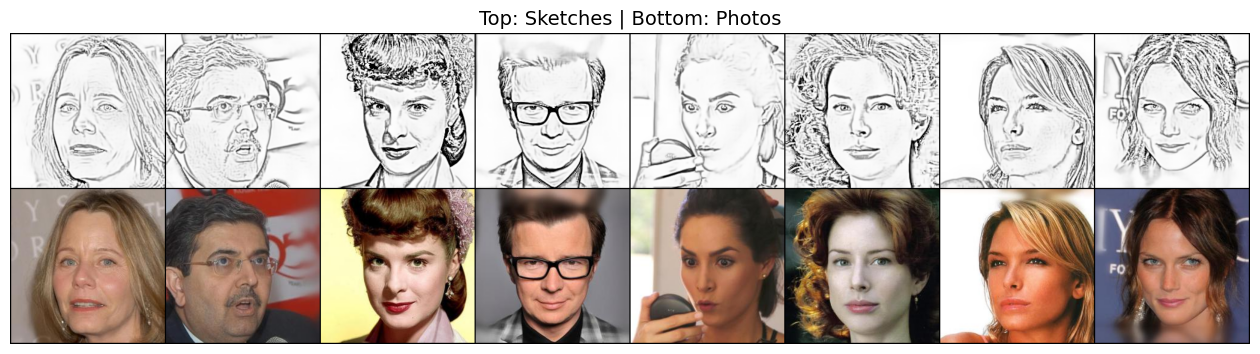

In [ ]:
# Get a batch
sketches, photos = next(iter(train_loader))
sketches, photos = sketches[:8], photos[:8]  # Select first 8 pairs

# Denormalize
def denormalize(tensor):
    return tensor * 0.5 + 0.5

sketches = denormalize(sketches)  # (8, 1, H, W)
photos = denormalize(photos)      # (8, 3, H, W)

# Stack them as [sk1, sk2, ..., sk8, img1, img2, ..., img8]
grid = torch.cat([sketches, photos], dim=0)  # (16, 3, H, W)
grid = vutils.make_grid(grid, nrow=8, padding=2)

# Plot
plt.figure(figsize=(16, 5))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Top: Sketches | Bottom: Photos", fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_sketch2image(generator, discriminator, dataloader):
    generator.eval()
    discriminator.eval()

    lpips_model = lpips.LPIPS(net='alex').to(device)
    resize = T.Resize((299, 299))
    normalize = T.Normalize([0.5]*3, [0.5]*3)

    psnr_list, ssim_list, lpips_list, disc_conf_list = [], [], [], []
    real_feats, fake_feats = [], []

    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = torch.nn.Identity()
    inception.eval()

    with torch.no_grad():
        for sketch, real in tqdm(dataloader, desc="Evaluating"):
            sketch = sketch.to(device)   # [B, 1, H, W]
            real = real.to(device)       # [B, 3, H, W]

            fake = generator(sketch)     # [B, 3, H, W]

            # LPIPS, PSNR, SSIM
            for i in range(fake.size(0)):
                real_i = real[i].cpu().numpy().transpose(1, 2, 0)
                fake_i = fake[i].cpu().numpy().transpose(1, 2, 0)

                real_i = np.clip(real_i, 0, 1)
                fake_i = np.clip(fake_i, 0, 1)

                psnr_list.append(psnr(real_i, fake_i, data_range=1.0))
                ssim_list.append(ssim(real_i, fake_i, data_range=1.0, win_size=3, channel_axis=-1))
                lpips_list.append(lpips_model(fake[i:i+1], real[i:i+1]).item())

            # PatchGAN Discriminator confidence
            disc_conf_list.append(discriminator(sketch, fake).mean().item())

            # Resize for Inception (for FID)
            real_resized = resize(real)
            fake_resized = resize(fake)

            real_feats.append(inception(normalize(real_resized)).cpu().numpy())
            fake_feats.append(inception(normalize(fake_resized)).cpu().numpy())

    # FID Calculation
    real_feats = np.concatenate(real_feats, axis=0)
    fake_feats = np.concatenate(fake_feats, axis=0)
    mu1, sigma1 = real_feats.mean(0), np.cov(real_feats, rowvar=False)
    mu2, sigma2 = fake_feats.mean(0), np.cov(fake_feats, rowvar=False)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

    # Print clean summary
    print("\n📊 Evaluation Results")
    print(f"🔹 PSNR:               {np.mean(psnr_list):.2f}")
    print(f"🔹 SSIM:               {np.mean(ssim_list):.4f}")
    print(f"🔹 LPIPS:              {np.mean(lpips_list):.4f}")
    print(f"🔹 FID:                {fid:.2f}")
    print(f"🔹 Disc Confidence:    {np.mean(disc_conf_list):.4f}")

    return {
        "PSNR": np.mean(psnr_list),
        "SSIM": np.mean(ssim_list),
        "LPIPS": np.mean(lpips_list),
        "FID": fid,
        "Disc_Confidence": np.mean(disc_conf_list)
    }

In [ ]:
def setup_fixed_batch(loader, device, num_samples=5):
    """Call once before training to fix a sketch-photo batch for visualization."""
    sketches, photos = next(iter(loader))
    return sketches[:num_samples].to(device), photos[:num_samples].to(device)

def denormalize(tensor):
    """Convert from [-1, 1] to [0, 1] range for visualization."""
    return tensor * 0.5 + 0.5

def save_epoch_samples(G, sketches_fixed, epoch, save_dir="training_progress"):
    """Saves side-by-side sketch → fake image results for a fixed batch."""
    os.makedirs(save_dir, exist_ok=True)
    G.eval()

    with torch.no_grad():
        fakes = G(sketches_fixed.to(next(G.parameters()).device))


    # Denormalize both sketches and fakes
    sketches_fixed = denormalize(sketches_fixed.cpu())
    fakes = denormalize(fakes.cpu())

    # Concatenate: first row = sketch, second row = generated photo
    grid = torch.cat([sketches_fixed, fakes], dim=0)
    grid = vutils.make_grid(grid, nrow=sketches_fixed.size(0), padding=2)

    save_path = os.path.join(save_dir, f"epoch_{epoch:03d}.png")
    save_image(grid, save_path)

    G.train()



In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.down1 = UNetBlock(in_channels, 64, down=True, use_dropout=False)
        self.down2 = UNetBlock(64, 128)
        self.down3 = UNetBlock(128, 256)
        self.down4 = UNetBlock(256, 512)
        self.down5 = UNetBlock(512, 512)
        self.down6 = UNetBlock(512, 512)
        self.down7 = UNetBlock(512, 512)
        self.down8 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # Decoder
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        bottleneck = self.down8(d7)

        # Decoder with skip connections
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        out = self.final(torch.cat([u7, d1], dim=1))
        return out


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=6):
        super().__init__()
        def block(in_c, out_c, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, stride, 1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.model = nn.Sequential(
            block(in_channels, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, 1, 1)  # Output: Patch matrix
        )

    def forward(self, x, y):
        # Concatenate sketch and photo: (B, 1+3, H, W)
        input = torch.cat([x, y], dim=1)
        return self.model(input)

In [ ]:
# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 2e-4
LAMBDA_L1 = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_SAMPLE_EVERY = 5

fixed_sketches, fixed_photos = setup_fixed_batch(val_loader, DEVICE, num_samples=5)
eval_history = []

In [ ]:
G = UNetGenerator().to(DEVICE)
D = PatchDiscriminator().to(DEVICE)

bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)


In [ ]:
def save_sample(sketches, real_images, fake_images, epoch):
    sketches = denormalize(sketches)  # make sketches 3-channel
    real_images = denormalize(real_images)
    fake_images = denormalize(fake_images)

    # Interleave them: sketch, fake, real
    combined = torch.cat([sketches, fake_images, real_images], dim=0)
    grid = vutils.make_grid(combined, nrow=5, padding=5)

    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Epoch {epoch} - Sketch | Generated | Real")
    plt.axis('off')
    plt.show()


for epoch in range(1, EPOCHS + 1):
    G.train()
    D.train()
    for batch in tqdm(train_loader, desc="Training"):
        sketches, real_images = batch
        sketches = sketches.to(DEVICE)
        real_images = real_images.to(DEVICE)

        #######################
        # Train Discriminator #
        #######################
        fake_images = G(sketches)

        D_real = D(sketches, real_images)
        D_fake = D(sketches, fake_images.detach())

        real_labels = torch.ones_like(D_real)
        fake_labels = torch.zeros_like(D_fake)

        D_loss_real = bce_loss(D_real, real_labels)
        D_loss_fake = bce_loss(D_fake, fake_labels)
        D_loss = (D_loss_real + D_loss_fake) * 0.5

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        ##################
        # Train Generator#
        ##################
        D_output_fake = D(sketches, fake_images)
        G_adv_loss = bce_loss(D_output_fake, real_labels)
        G_l1_loss = l1_loss(fake_images, real_images)

        # Total Generator Loss
        G_loss = G_adv_loss + LAMBDA_L1 * G_l1_loss

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{EPOCHS}]  D Loss: {D_loss.item():.4f}  G Loss: {G_loss.item():.4f}")
    scheduler_G.step()
    scheduler_D.step()
    save_epoch_samples(G, fixed_sketches, epoch)
    # Save sample outputs
    if epoch % SAVE_SAMPLE_EVERY == 0:
        torch.save(G.state_dict(), f"pix2pix_generator_epoch{epoch}.pth")
        G.eval()
        metrics = evaluate_sketch2image(G, D, val_loader)  # or a small validation dataloader
        metrics["Epoch"] = epoch
        eval_history.append(metrics)
        pd.DataFrame(eval_history).to_csv("eval_metrics.csv", index=False)
        with torch.no_grad():
            sketches, real_images = next(iter(val_loader))
            sketches = sketches[:5].to(DEVICE)
            real_images = real_images[:5].to(DEVICE)
            fake_images = G(sketches)
            save_sample(sketches, real_images, fake_images, epoch)


In [ ]:
df = pd.read_csv("eval_metrics.csv")

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(df["Epoch"], df["PSNR"], label="PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("PSNR over Epochs")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(df["Epoch"], df["SSIM"], label="SSIM", color="orange")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM over Epochs")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(df["Epoch"], df["LPIPS"], label="LPIPS", color="green")
plt.xlabel("Epoch")
plt.ylabel("LPIPS")
plt.title("LPIPS over Epochs (Lower is Better)")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(df["Epoch"], df["FID"], label="FID", color="red")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID over Epochs (Lower is Better)")
plt.grid()

plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

In [ ]:
def create_training_gif(save_dir="training_progress", gif_name="training_progress.gif", fps=10):
    images = []
    for epoch in sorted(os.listdir(save_dir)):
        if epoch.endswith(".png"):
            images.append(imageio.imread(os.path.join(save_dir, epoch)))
    imageio.mimsave(gif_name, images, fps=fps)

create_training_gif()

In [ ]:
# Save Generator model
torch.save(G.state_dict(), "pix2pix_generator.pth")

In [ ]:
evaluation_metrics= evaluate_sketch2image(G,D,val_loader)

In [ ]:
# Get a single batch from the loader
sketches, real_images = next(iter(val_loader))

# Select one sample
sketch = sketches[0]           # Shape: (1, H, W)
real_image = real_images[0]    # Optional: For comparison


G = UNetGenerator().to(DEVICE)
G.load_state_dict(torch.load("pix2pix_generator.pth",weights_only=True))
G.eval()

with torch.no_grad():
    sketch_input = sketch.unsqueeze(0).to(DEVICE)  # Add batch dimension → (1, 1, H, W)
    fake_image = G(sketch_input)

In [ ]:
def denormalize(t):
    return t * 0.5 + 0.5

import matplotlib.pyplot as plt

sketch_np = denormalize(sketch).squeeze().permute(1, 2, 0).cpu().numpy()
fake_np = denormalize(fake_image.squeeze()).permute(1, 2, 0).cpu().numpy()
real_np = denormalize(real_image).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Sketch")
plt.imshow(sketch_np)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Generated Image")
plt.imshow(fake_np)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth")
plt.imshow(real_np)
plt.axis('off')

plt.show()


#Image to Sketch


##Novel

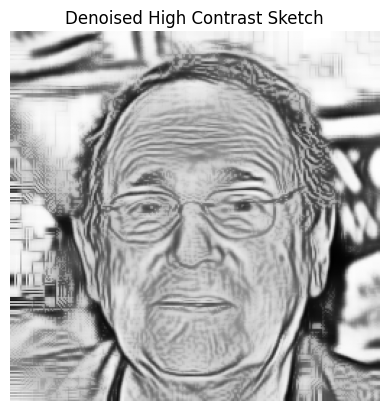

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def high_contrast_lattice_sketch_denoised(image_path, save_path='denoised_high_contrast_sketch.jpg'):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Pre-sharpen to bring out details
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(gray, -1, sharpen_kernel)

    # Invert and blend using dodge technique
    inverted = 255 - sharpened
    blur = cv2.GaussianBlur(inverted, (21, 21), 0)
    dodge = cv2.divide(sharpened, 255 - blur, scale=256)

    # Boost contrast
    sketch = cv2.equalizeHist(dodge)

    # Optional denoising (Non-local Means)
    sketch = cv2.fastNlMeansDenoising(sketch, h=75, templateWindowSize=7, searchWindowSize=21)

    # Save and display
    cv2.imwrite(save_path, sketch)
    plt.imshow(sketch, cmap='gray')
    plt.title("Denoised High Contrast Sketch")
    plt.axis('off')
    plt.show()


# folder_path ='/content/celeba_hq_256/celeba_hq_256/00001.jpg'

# # 🎲 Pick a random image
# random_image_name = random.choice(os.listdir(folder_path))
# random_image_path = os.path.join(folder_path, random_image_name)

# 🖼️ Run sketch function
high_contrast_lattice_sketch_denoised('./celeba_hq_256/celeba_hq_256/00001.jpg')


##Sobel sketch maker

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Read image in grayscale
img = cv2.imread('30.jpg', cv2.IMREAD_GRAYSCALE)

# 2. Apply Sobel filters in X and Y directions
sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # dx=1, dy=0
sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # dx=0, dy=1

# 3. Convert the results to absolute values, then to uint8
abs_sobel_x = cv2.convertScaleAbs(sobel_x)
abs_sobel_y = cv2.convertScaleAbs(sobel_y)

# 4. Combine them (typical choice is a weighted sum)
sobel_combined = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
inverted_edges = 255 - sobel_combined
output_path = 'sketch_output.jpg'  # Replace with the desired output path
cv2.imwrite(output_path, inverted_edges)


# 5. Save or display results
# cv2.imwrite('sobel_output.jpg', sobel_combined)

plt.imshow(inverted_edges, cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')
plt.show()


##Sobel Without Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Read image in grayscale
img = cv2.imread('30.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Image not found!")

# 2. Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(img, (5, 5), 1.2)

# 3. Define Sobel kernels
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y_kernel = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

# 4. Manual convolution
def convolve(img, kernel):
    h, w = img.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded = np.pad(img, pad, mode='reflect')
    output = np.zeros_like(img, dtype=np.float32)

    for i in range(h):
        for j in range(w):
            roi = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(roi * kernel)
    return output

# 5. Apply Sobel filters
grad_x = convolve(blurred, sobel_x_kernel)
grad_y = convolve(blurred, sobel_y_kernel)

# 6. Compute gradient magnitude
gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

# Normalize to 0–255
gradient_mag = np.uint8(255 * gradient_mag / np.max(gradient_mag))

# 7. Optional threshold to remove weak edges
_, thresholded = cv2.threshold(gradient_mag, 40, 255, cv2.THRESH_TOZERO)

# 8. Invert for sketch-like look
inverted = 255 - thresholded

# 9. Optional smooth final output for aesthetics
sketch = cv2.bilateralFilter(inverted, d=5, sigmaColor=50, sigmaSpace=50)

# 10. Save and show
cv2.imwrite('improved_sobel_sketch.jpg', sketch)

plt.imshow(sketch, cmap='gray')
plt.title("Improved Sobel Sketch")
plt.axis('off')
plt.show()


##Canny Without Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_blur(image, kernel_size=5, sigma=1.4):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def sobel_filters(img):
    # Use OpenCV's Sobel which handles borders better
    Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.hypot(Ix, Iy)
    angle = np.arctan2(Iy, Ix)

    magnitude = magnitude / magnitude.max() * 255
    return magnitude.astype(np.uint8), angle

def non_max_suppression(mag, angle):
    M, N = mag.shape
    output = np.zeros((M, N), dtype=np.uint8)
    angle = angle * 180 / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q, r = 255, 255
                a = angle[i, j]

                if (0 <= a < 22.5) or (157.5 <= a <= 180):
                    q = mag[i, j + 1]
                    r = mag[i, j - 1]
                elif (22.5 <= a < 67.5):
                    q = mag[i + 1, j - 1]
                    r = mag[i - 1, j + 1]
                elif (67.5 <= a < 112.5):
                    q = mag[i + 1, j]
                    r = mag[i - 1, j]
                elif (112.5 <= a < 157.5):
                    q = mag[i - 1, j - 1]
                    r = mag[i + 1, j + 1]

                if mag[i, j] >= q and mag[i, j] >= r:
                    output[i, j] = mag[i, j]
                else:
                    output[i, j] = 0

            except IndexError:
                pass

    return output

def threshold(image, low_ratio=0.05, high_ratio=0.15):
    high_threshold = image.max() * high_ratio
    low_threshold = high_threshold * low_ratio

    M, N = image.shape
    res = np.zeros((M, N), dtype=np.uint8)

    strong = np.uint8(255)
    weak = np.uint8(75)

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak=75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i, j] == weak:
                # Check 8-neighbors for a strong edge
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def custom_canny(image, low_ratio=0.05, high_ratio=0.15):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = gaussian_blur(gray, kernel_size=5, sigma=1.4)
    mag, angle = sobel_filters(blurred)
    nms = non_max_suppression(mag, angle)
    thresh, weak, strong = threshold(nms, low_ratio, high_ratio)
    result = hysteresis(thresh, weak, strong)
    return result

# ---------- Main ----------
input_path = '30.jpg'
img = cv2.imread(input_path)

if img is None:
    raise FileNotFoundError(f"Image not found at path: {input_path}")

edges_improved = custom_canny(img)

# Save and show
cv2.imwrite('improved_custom_canny.jpg', 255 - edges_improved)

plt.imshow(255 - edges_improved, cmap='gray')
plt.title('Improved Custom Canny Edge Detector')
plt.axis('off')
plt.show()


##Edge-Enhanced Dodge Sketching

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sketch conversion function
def convert_to_sketch(image):
    image_np = np.array(image.convert("RGB"))
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    inverted = 255 - gray
    blur = cv2.GaussianBlur(inverted, (21, 21), sigmaX=0, sigmaY=0)
    dodge = cv2.divide(gray, 255 - blur, scale=256)
    edges = cv2.Laplacian(gray, cv2.CV_8U, ksize=5)
    edges = cv2.GaussianBlur(edges, (3, 3), 0)
    sketch = cv2.subtract(dodge, edges // 3)
    sketch = np.clip(sketch, 0, 255).astype(np.uint8)
    sketch = cv2.fastNlMeansDenoising(sketch, h=15, templateWindowSize=7, searchWindowSize=21)
    return Image.fromarray(sketch).convert("RGB")

# Load input image
input_image = Image.open("30.jpg")

# Convert to sketch
sketch_image = convert_to_sketch(input_image)

# Plot both images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Sketch")
plt.imshow(sketch_image)
plt.axis('off')

plt.tight_layout()
plt.show()


# Clip installation

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ch1fjv_h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ch1fjv_h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=617b16c6ce57c48d6bc0c8001453ffe4fd5da72f172010a4038922a69f634426
  Stored in directory: /tmp/pip-ephem-wheel-cache-3xusjdhi/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


#Temp CLIP

In [ ]:
# %% [markdown]
# # Integrated Image-to-Sketch and Sketch-to-Image Conversion Project
#
# This notebook provides two key functionalities:
#
# 1. **Text-to-Image Retrieval and Sketch Generation:**
#    Given a text query, the system retrieves the top 5 images from a provided folder using a CLIP-based retrieval mechanism and then computes a sketch for each using Sobel edge detection.
#
# 2. **Image-to-Sketch with Caption Generation:**
#    Given an image, the system computes its sketch using Sobel edge detection and then generates a caption using a pretrained image captioning model.
#
# Make sure you have an image folder (e.g. `./images`) with some images for testing.

# %%
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import clip
from tqdm import tqdm
import torchvision.transforms as transforms
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

# %% [markdown]
# ## Utility Function: Sobel Edge Detection for Sketch Generation
#
# This function reads an image (in grayscale) and applies Sobel filters to generate a sketch. An optional inversion is provided so that the output looks like a pencil sketch.

# %%
def generate_sketch(image_path, output_path=None, invert=True):
    """
    Generate a sketch from an image using Sobel edge detection.

    Args:
        image_path (str): Path to the input image.
        output_path (str, optional): If provided, the sketch is saved to this path.
        invert (bool): If True, the edge image is inverted.

    Returns:
        np.array: The resulting sketch image.
    """
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image {image_path} not found.")
    # Apply Sobel filters in X and Y directions
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Convert results to absolute values and then to uint8
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    # Combine the gradients (weighted sum)
    sobel_combined = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    # Invert edges for a sketch-like appearance if needed
    sketch = 255 - sobel_combined if invert else sobel_combined
    if output_path:
        cv2.imwrite(output_path, sketch)
    return sketch

# %% [markdown]
# ## CLIP Retrieval Setup
#
# We use the CLIP model to retrieve images that match a given text query.
#
# The following functions load images from a folder, compute their features, and perform retrieval based on cosine similarity.

# %%
# Set up device and load CLIP model and its preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

def load_images_from_folder(image_folder):
    """
    Loads image file paths from the provided folder.
    """
    image_paths = []
    for img_name in os.listdir(image_folder):
        full_path = os.path.join(image_folder, img_name)
        if os.path.isfile(full_path):
            image_paths.append(full_path)
    return image_paths

def compute_image_features(image_paths, preprocess, model, device, batch_size=32):
    """
    Computes features for all images in the provided list using the given model.
    """
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        for path in batch_paths:
            image = Image.open(path).convert("RGB")
            image = preprocess(image)
            images.append(image)
        images = torch.stack(images).to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
        features.append(image_features)
    features = torch.cat(features, dim=0)
    return features

def perform_retrieval_clip(query, image_features, model, device):
    """
    Given a text query, returns the indices of the top 5 most similar images based on cosine similarity.
    """
    text_input = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    cos_similarities = (text_features @ image_features.T).squeeze(0)
    sorted_indices = torch.argsort(cos_similarities, descending=True)
    top_5_indices = sorted_indices[:5].tolist()
    return top_5_indices

# %% [markdown]
# ## Image Captioning Setup
#
# We use a pretrained image captioning model from Hugging Face to generate captions for a given image.
# In this example we use the `nlpconnect/vit-gpt2-image-captioning` model.

# %%
# Load the captioning model and corresponding processors
caption_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

def generate_caption(image_path, max_length=16, num_beams=4):
    """
    Generates a caption for the image located at image_path.
    """
    image = Image.open(image_path).convert("RGB")
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = caption_model.generate(pixel_values, max_length=max_length, num_beams=num_beams)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

# %% [markdown]
# ## Functionality 1: Retrieve Images and Generate Sketches from a Text Query
#
# This function takes a text query and an image folder, retrieves the top 5 images using CLIP retrieval, and then generates a sketch for each using the Sobel edge detector.

# %%
def retrieve_images_and_sketches(query, image_folder):
    """
    Given a text query and an image folder, retrieve the top 5 images using CLIP-based retrieval
    and generate their sketches using Sobel edge detection.

    Args:
        query (str): The text query.
        image_folder (str): Path to the folder containing images.

    Returns:
        List[dict]: A list of dictionaries, each with keys:
                    - 'image_path': path of the retrieved image
                    - 'sketch': the sketch (numpy array) generated from the image.
    """
    # Load image paths from the folder
    image_paths = load_images_from_folder(image_folder)
    if not image_paths:
        raise ValueError("No images found in the provided folder.")

    # Compute features for all images
    image_features = compute_image_features(image_paths, preprocess_clip, model_clip, device)

    # Retrieve top 5 images using CLIP retrieval
    top_indices = perform_retrieval_clip(query, image_features, model_clip, device)

    results = []
    for idx in top_indices:
        img_path = image_paths[idx]
        sketch = generate_sketch(img_path)
        results.append({
            "image_path": img_path,
            "sketch": sketch
        })
    return results

# %% [markdown]
# ## Functionality 2: Create Sketch and Generate Caption for a Given Image
#
# This function takes an image path, computes its sketch using the Sobel edge detector, and generates a caption using the image captioning model.

# %%
def create_sketch_and_caption(image_path):
    """
    Given an image, create a sketch using Sobel edge detection and generate a caption for the image.

    Args:
        image_path (str): Path to the input image.

    Returns:
        dict: A dictionary with keys:
              - 'sketch': the computed sketch (numpy array)
              - 'caption': the generated caption for the image.
    """
    sketch = generate_sketch(image_path)
    caption = generate_caption(image_path)
    return {"sketch": sketch, "caption": caption}

# %% [markdown]
# ## Demonstration and Testing
#
# The following cell demonstrates how to call the two main functionalities.
#
# **Note:**
# - Update the `image_folder` variable to point to your dataset folder.
# - The first part demonstrates retrieval by text query and shows the corresponding sketches.
# - The second part demonstrates generating a sketch and caption from a single image.

# %%
# Set the image folder path (make sure this folder exists and contains images)
image_folder = "./images"  # Change this path as needed

# --- Functionality 1: Text-to-Image Retrieval and Sketch Generation ---
query = "a beautiful landscape"  # Example text query
print("Retrieving images for query:", query)
try:
    retrieval_results = retrieve_images_and_sketches(query, image_folder)
    for i, res in enumerate(retrieval_results, 1):
        print(f"Result {i}: {res['image_path']}")
        plt.figure()
        plt.imshow(res['sketch'], cmap='gray')
        plt.title(f"Sketch of {os.path.basename(res['image_path'])}")
        plt.axis('off')
        plt.show()
except Exception as e:
    print("Error during retrieval:", e)

# --- Functionality 2: Image-to-Sketch with Caption Generation ---
# For demonstration, we use the first image from the folder.
image_files = os.listdir(image_folder)
if image_files:
    test_image_path = os.path.join(image_folder, image_files[0])
    print("\nGenerating sketch and caption for image:", test_image_path)
    result = create_sketch_and_caption(test_image_path)
    print("Generated Caption:", result["caption"])
    plt.figure()
    plt.imshow(result["sketch"], cmap='gray')
    plt.title("Sketch of the Image")
    plt.axis('off')
    plt.show()
else:
    print("No images found in the folder for testing.")



In [ ]:
#Random Sketch

test_sketch = generate_sketch("./images/30.jpg")
plt.imshow(test_sketch, cmap='gray')
plt.title("Test Sketch")
plt.axis('off')
plt.show()

In [ ]:
#Sketch from query

query = "-"  # or any query relevant to your dataset
print("Retrieving images for query:", query)
try:
    retrieval_results = retrieve_images_and_sketches(query, image_folder)
    for i, res in enumerate(retrieval_results, 1):
        print(f"Result {i}: {res['image_path']}")
        plt.figure()
        plt.imshow(res['sketch'], cmap='gray')
        plt.title(f"Sketch of {os.path.basename(res['image_path'])}")
        plt.axis('off')
        plt.show()
except Exception as e:
    print("Error during retrieval:", e)


In [ ]:
#Sketch and caption generation

image_files = os.listdir(image_folder)
if image_files:
    test_image_path = os.path.join(image_folder, "30.jpg")
    print("\nGenerating sketch and caption for image:", test_image_path)
    result = create_sketch_and_caption(test_image_path)
    print("Generated Caption:", result["caption"])
    plt.figure()
    plt.imshow(result["sketch"], cmap='gray')
    plt.title("Sketch of the Image")
    plt.axis('off')
    plt.show()
else:
    print("No images found in the folder for testing.")


#Sketch to Image Using Custom Model

In [ ]:
import os
import cv2
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from torchvision import transforms
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# --- Image to sketch conversion using Sobel (or your custom function) ---
def image_to_sketch(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sketch = cv2.convertScaleAbs(cv2.addWeighted(cv2.convertScaleAbs(sobelx), 0.5, cv2.convertScaleAbs(sobely), 0.5, 0))
    sketch = 255 - sketch
    return Image.fromarray(sketch)

# --- Load dataset and convert to sketch-image pairs ---
def process_dataset(dataset_path, max_images=None):
    sketch_embeddings = []
    image_embeddings = []
    image_paths = []
    image_count = 0

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                try:
                    path = os.path.join(root, file)
                    print(f"[{image_count + 1}] Processing: {file}")
                    img = Image.open(path).convert("RGB")
                    sketch = image_to_sketch(img)

                    sketch_tensor = clip_preprocess(sketch).unsqueeze(0).to(device)
                    img_tensor = clip_preprocess(img).unsqueeze(0).to(device)

                    with torch.no_grad():
                        sketch_feat = clip_model.encode_image(sketch_tensor).cpu().numpy().flatten()
                        image_feat = clip_model.encode_image(img_tensor).cpu().numpy().flatten()

                    sketch_embeddings.append(sketch_feat)
                    image_embeddings.append(image_feat)
                    image_paths.append(path)

                    image_count += 1
                    if max_images is not None and image_count >= max_images:
                        print(f"\n✅ Reached max_images = {max_images}, stopping...")
                        return np.array(sketch_embeddings), np.array(image_embeddings), image_paths

                except Exception as e:
                    print(f"❌ Failed on {file}: {e}")

    return np.array(sketch_embeddings), np.array(image_embeddings), image_paths


# def process_dataset(dataset_path):
#     sketch_embeddings = []
#     image_embeddings = []
#     image_paths = []

#     for root, _, files in os.walk(dataset_path):
#         for file in files:
#             try:
#                 path = os.path.join(root, file)
#                 img = Image.open(path).convert("RGB")
#                 sketch = image_to_sketch(img)

#                 sketch_tensor = clip_preprocess(sketch).unsqueeze(0).to(device)
#                 img_tensor = clip_preprocess(img).unsqueeze(0).to(device)

#                 with torch.no_grad():
#                     sketch_feat = clip_model.encode_image(sketch_tensor).cpu().numpy().flatten()
#                     image_feat = clip_model.encode_image(img_tensor).cpu().numpy().flatten()

#                 sketch_embeddings.append(sketch_feat)
#                 image_embeddings.append(image_feat)
#                 image_paths.append(path)

#             except Exception as e:
#                 print(f"Failed on {file}: {e}")

#     return np.array(sketch_embeddings), np.array(image_embeddings), image_paths

# --- Train NearestNeighbors model on image embeddings ---
# def train_retriever(image_embeddings):
#     nn = NearestNeighbors(n_neighbors=3, metric='cosine')
#     nn.fit(image_embeddings)
#     return nn

def train_retriever_on_sketch_embeddings(sketch_embeddings):
    nn = NearestNeighbors(n_neighbors=3, metric='cosine')
    nn.fit(sketch_embeddings)
    return nn

# --- Save everything ---
def save_all(sketch_embeds, image_embeds, paths, model, out_dir="model_files"):
    os.makedirs(out_dir, exist_ok=True)
    np.save(f"{out_dir}/sketch_embeddings.npy", sketch_embeds)
    np.save(f"{out_dir}/image_embeddings.npy", image_embeds)
    with open(f"{out_dir}/image_paths.pkl", "wb") as f:
        pickle.dump(paths, f)
    with open(f"{out_dir}/nn_model.pkl", "wb") as f:
        pickle.dump(model, f)

def retrieve_images_from_sketch_using_sketch_embeddings(sketch_path, model_dir="model_files"):
    with open(f"{model_dir}/nn_model.pkl", "rb") as f:
        nn_model = pickle.load(f)
    with open(f"{model_dir}/image_paths.pkl", "rb") as f:
        image_paths = pickle.load(f)
    sketch_embeddings = np.load(f"{model_dir}/sketch_embeddings.npy")

    sketch_img = Image.open(sketch_path).convert("RGB")
    sketch = image_to_sketch(sketch_img)
    sketch_tensor = clip_preprocess(sketch).unsqueeze(0).to(device)

    with torch.no_grad():
        sketch_embed = clip_model.encode_image(sketch_tensor).cpu().numpy()

    dists, indices = nn_model.kneighbors(sketch_embed)
    return [image_paths[i] for i in indices[0]]


In [ ]:
# Downloading Flicker8k Dataset

import matplotlib.pyplot as plt
import random
import glob
from PIL import Image
import os

dataset_path = "./Flickr8k_Dataset/Flicker8k_Dataset"
# dataset_path = "./Flickr8k_Dataset"

# List all image paths directly
image_paths = glob.glob(os.path.join(dataset_path, "*.jpg"))

# Pick a random image
sample_image_path = random.choice(image_paths)

# Show the image
img = Image.open(sample_image_path)
plt.imshow(img, cmap='gray')
plt.title(f"Sample image: {os.path.basename(sample_image_path)}")
plt.axis("off")
plt.show()


In [ ]:
# Training model on dataset

dataset_path = "./Flickr8k_Dataset/Flicker8k_Dataset"

# Step 1: Extract features
sketch_feats, image_feats, image_paths = process_dataset(dataset_path, max_images=7900)

# Step 2: Train Nearest Neighbor model on sketch embeddings
nn_model = train_retriever_on_sketch_embeddings(sketch_feats)

# Step 3: Save
save_all(sketch_feats, image_feats, image_paths, nn_model)

# # Step 4: Retrieve using sketch embedding
# query_sketch = "input_sketch.jpg"
# top_real_images = retrieve_images_from_sketch_using_sketch_embeddings(query_sketch)
# print(top_real_images)


In [ ]:
import random
import matplotlib.pyplot as plt

# Set your dataset path
dataset_path = "./Flickr8k_Dataset/Flicker8k_Dataset"

# Get all image paths
all_images = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            all_images.append(os.path.join(root, file))

# Pick a random image
random_image_path = random.choice(all_images)
original_img = Image.open(random_image_path).convert("RGB")

# Convert to sketch using the defined function
sketch_img = image_to_sketch(original_img)

# Display both images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sketch_img, cmap='gray')
plt.title("Sketch Image")
plt.axis("off")

plt.show()


#Face Detection

In [ ]:
pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import torch

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# mtcnn = MTCNN(keep_all=True, device=device)

# def detect_faces_in_sketch(sketch_path):
#     img = Image.open(sketch_path).convert("RGB")
#     boxes, _ = mtcnn.detect(img)

#     if boxes is None:
#         print("❌ No face detected.")
#         return False

#     print(f"✅ Detected {len(boxes)} face(s).")
#     # Show result
#     plt.imshow(img)
#     ax = plt.gca()
#     for box in boxes:
#         x1, y1, x2, y2 = box
#         rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
#                              fill=False, color='red', linewidth=2)
#         ax.add_patch(rect)
#     plt.axis('off')
#     plt.show()
#     return True

# # Example usage
# detect_faces_in_sketch("face8.jpg")

def is_mostly_face(sketch_path, face_area_threshold=0.25, visualize=True):
    img = Image.open(sketch_path).convert("RGB")
    width, height = img.size
    image_area = width * height

    boxes, _ = mtcnn.detect(img)

    if boxes is None:
        print("❌ No face detected.")
        return False

    # Compute face areas
    face_areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
    max_face_area = max(face_areas)
    face_ratio = max_face_area / image_area

    print(f"✅ Detected {len(boxes)} face(s). Largest face covers {face_ratio*100:.2f}% of image.")

    if visualize:
        plt.imshow(img)
        ax = plt.gca()
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
        plt.axis('off')
        plt.show()

    return face_ratio >= face_area_threshold


✅ Detected 1 face(s). Largest face covers 26.33% of image.


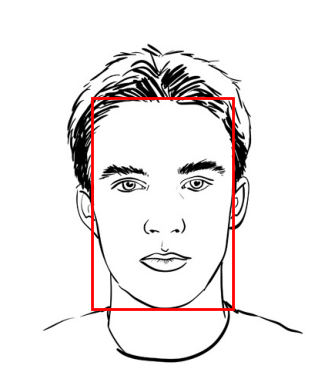

👉 Use Pix2Pix model (face sketch).


In [ ]:
if is_mostly_face("face9.jpeg"):
    print("👉 Use Pix2Pix model (face sketch).")
else:
    print("👉 Use general image retrieval (not mostly face).")


# Final Sketch to Image

In [ ]:
def generate_image_from_sketch(sketch_path):
    if is_mostly_face(sketch_path):
        return generate_image_pix2pix(sketch_path)
    else:
        return generate_image_custom(sketch_path)

#Content Based Feature Extraction

In [ ]:
# Generate Caption
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP captioning model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_blip_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

In [ ]:
# Retrieve Images from Text Query
def retrieve_images_clip(query, image_folder, top_k=5):
    image_paths = load_images_from_folder(image_folder)
    image_features = compute_image_features(image_paths, preprocess_clip, model_clip, device)

    text_input = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model_clip.encode_text(text_input)

    similarities = (text_features @ image_features.T).squeeze(0)
    top_indices = torch.argsort(similarities, descending=True)[:top_k]

    results = [image_paths[i] for i in top_indices]
    return results


In [ ]:
caption = generate_blip_caption("30.jpg")
print("Caption:", caption)

Caption: a young girl is fucked and fucked by a guy


In [ ]:
import os
import torch
import clip
from PIL import Image
from torchvision import transforms

# Load CLIP model and preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

# Load images from folder
def load_images_from_folder(folder):
    image_paths = []
    for filename in sorted(os.listdir(folder))[:200]:  # Only first 200
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(folder, filename))
    return image_paths

# Compute image features using CLIP
def compute_image_features(image_paths, preprocess, model, device, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        for path in batch_paths:
            image = Image.open(path).convert("RGB")
            image = preprocess(image)
            images.append(image)
        images = torch.stack(images).to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
        features.append(image_features)
    features = torch.cat(features, dim=0)
    return features


In [ ]:
def retrieve_images_clip(query, image_folder, top_k=5):
    import os
    from PIL import Image
    import torch
    import clip
    import torchvision.transforms as transforms

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    image_paths = []
    for filename in sorted(os.listdir(image_folder))[:200]:  # LIMIT to 200
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(image_folder, filename))

    images = [preprocess(Image.open(p).convert("RGB")).unsqueeze(0) for p in image_paths]
    images = torch.cat(images).to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        text_features = model.encode_text(clip.tokenize([query]).to(device))

    similarities = (image_features @ text_features.T).squeeze()
    top_indices = similarities.topk(top_k).indices

    top_image_paths = [image_paths[i] for i in top_indices]
    return top_image_paths


Top 3 images for query: 'a girl with long hair'


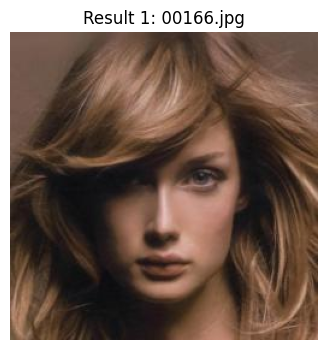

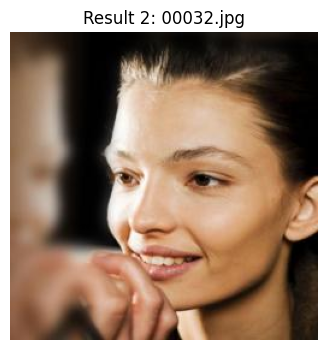

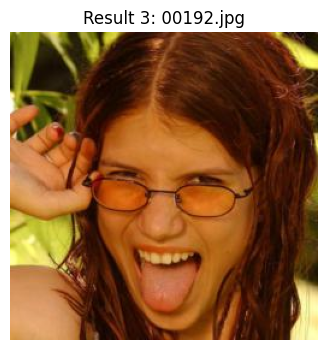

In [ ]:
query = "a girl with long hair"
image_folder = "./celeba_hq_256/celeba_hq_256"

retrieved_images = retrieve_images_clip(query, image_folder, top_k=3)

from PIL import Image
import matplotlib.pyplot as plt
import os

print(f"Top {len(retrieved_images)} images for query: '{query}'")
for i, img_path in enumerate(retrieved_images, 1):
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Result {i}: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()
